In [77]:
import scipy as sp
from scipy.io import loadmat
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import get_cmap, set_cmap
import os
from PIL import Image

In [78]:
data = loadmat("ECGData.mat")

In [79]:
data.keys(), type(data)

(dict_keys(['__header__', '__version__', '__globals__', 'ECGData']), dict)

In [80]:
data = data["ECGData"]
ecg = data["Data"][0][0]

In [81]:
labels = data["Labels"][0][0]
labels = [labels[i][0][0] for i in range(labels.size)]

In [82]:
sig_ARR, lab_ARR = ecg[0:95] , labels[0:95]
sig_CHF, lab_CHF = ecg[96:125] , labels[96:125]
sig_NSR, lab_NSR = ecg[125:161] , labels[126:161]



In [83]:
def butter_highpass_filter(data, cutoff=1, fs=128, order = 5):
    normal_cutoff = cutoff / (fs/ 2)
    b, a = signal.butter(order, normal_cutoff, btype="high", analog = False)
    y = signal.filtfilt(b, a, data)
    return y

def notch_filter(data, cutoff=60, fs=128, q = 30):
    normal_cutoff = cutoff / (fs/2)
    b, a = signal.iirnotch(normal_cutoff, Q=q, fs=fs)
    y = signal.filtfilt(b, a, data)
    return y

cutoff = 1
fs = 128

# sample = sig_ARR[0][0:1000]
# fig = plt.figure(1)
# plt.plot(sample)
# fig = plt.figure(2)
# sample_filtered = butter_highpass_filter(sample, cutoff=cutoff, fs= fs, order=5)
# plt.plot((sample_filtered))

Label: ARR	Index: 43
Label: CHF	Index: 8
Label: NSR	Index: 12


<Figure size 432x288 with 0 Axes>

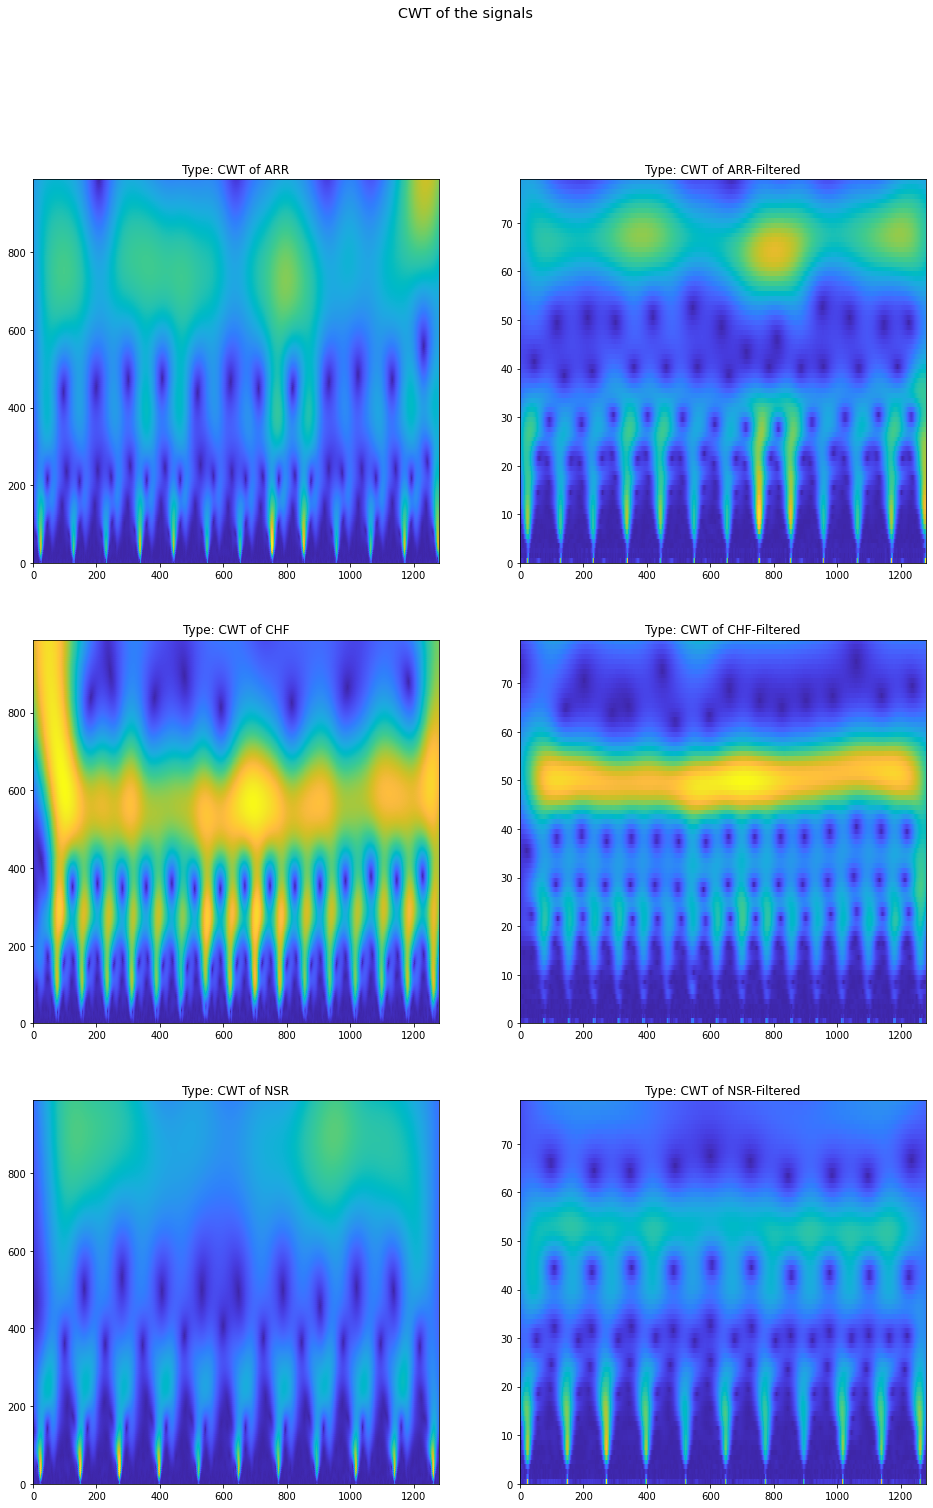

In [84]:
ind_ARR = np.random.randint(low = 0,high = sig_ARR.shape[0])
ind_CHF = np.random.randint(low = 0,high = sig_CHF.shape[0])
ind_NSR = np.random.randint(low = 0,high = sig_NSR.shape[0])

fig2 = plt.figure(2)
fig2, ax2 = plt.subplots(3,2)
fig2.suptitle("CWT of the signals", fontsize="x-large")
fig2.set_figheight(24)
fig2.set_figwidth(16)


# fig1 = plt.figure(1)
# fig1, ax1 = plt.subplots(3,2)
# fig1.suptitle("Signal", fontsize="x-large")
# fig1.set_figheight(24)
# fig1.set_figwidth(16)

for i, ind in enumerate([ind_ARR, ind_CHF, ind_NSR]):
    if i ==0:
        sig = sig_ARR[ind]
        sigf = butter_highpass_filter(sig)
        sigf = notch_filter(sigf)
        lab = lab_ARR[ind]
    elif i ==1:
        sig = sig_CHF[ind]
        sigf = butter_highpass_filter(sig)
        sigf = notch_filter(sigf)
        lab = lab_CHF[ind]
    elif i ==2:
        sig = sig_NSR[ind]
        sigf = butter_highpass_filter(sig)
        sigf = notch_filter(sig)
        lab = lab_NSR[ind]       



    sig = sig[5000:6280]
    sigf = sigf[5000:6280]
    if(np.max(sig) < np.abs(np.min(sig)) ):
        sig = -1*sig
    if(np.max(sigf) < np.abs(np.min(sigf)) ):
        sigf = -1*sigf    
    cwt = signal.cwt(sig, signal.morlet2, widths=np.arange(1,80,80/1000), w=3.5)
    cwtf = signal.cwt(sigf, signal.morlet2, widths=np.arange(1,80), w=8)
    

    # ax1[i, 0].plot(sig)
    # ax1[i, 0].set_title(f"Type: {lab}")
    # ax1[i, 1].plot(sigf)
    # ax1[i, 1].set_title(f"Type: {lab}-Filtered")

    ax2[i, 0].pcolormesh(np.abs(cwt), cmap="parula256")
    ax2[i, 0].set_title(f"Type: CWT of {lab}")
    ax2[i, 1].pcolormesh(np.abs(cwtf), cmap = "parula256")
    ax2[i, 1].set_title(f"Type: CWT of {lab}-Filtered")

    print(f"Label: {lab}\tIndex: {ind}")

In [85]:
# for i in range(0, sig_NSR.shape[0]):
#     fig = plt.figure(figsize=(20,4))
#     plt.plot(sig_NSR[i][0:6000])
#     plt.title(i)
#     plt.plot(notch_filter(butter_highpass_filter(sig_NSR[i][0:6000])))

In [98]:
def process_signal(data):
    data = butter_highpass_filter(data)
    data = notch_filter(data)
    return data


def create_save_wavelets(data:np.ndarray, name:str):

    
    [os.makedirs(x, exist_ok=True) for x in ["Dataset/ARR", "Dataset/CHF", "Dataset/NSR"]]

    path = "Dataset/" + name.upper()

    if not os.path.isdir(path):
        assert NotADirectoryError(f"{path} is not a valid path")

    sig_len = data.shape[1]

    for i, sig in enumerate(data):
        
        if(np.max(sig) < np.abs(np.min(sig)) ):
            sig = -1*sig
        sig = process_signal(sig)

        start = [5000, 7000, 10000,13000, 15000, 17000, 20000,23000, 25000,27000, 30000,33000, 35000, 40000,45000,47000, 50000,53000, 55000, 57000, 60000]
        stop = [x+1280 for x in start]  

        if name == "ARR":
            start = start[0::3]
            stop = [x+1280 for x in start]
        if name == "CHF":
            start = start[:-2]

        cnt = 0
        for k,l in zip(start, stop):
            imdir = path +"/"+ name+"_"+str(i)+"_"+str(cnt)+".png"
            cwt = signal.cwt(sig[k:l], signal.morlet2, widths=np.arange(1,101,100/1000), w=3.5)
            cwt = np.abs(cwt)
            cm = get_cmap('viridis')
            # cwt = ((cwt - np.min(cwt))*255)/ (np.max(cwt) - np.min(cwt))
            cwt = (cm(cwt)[:,:,:3]*255).astype(np.uint8)
            # print(np.max(cwt), np.min(cwt))
            result = Image.fromarray(cwt)
            # result = result.convert("RGB")
            result = result.resize((224,224), resample = Image.BICUBIC)
            result.save(imdir, format="png")
            cnt += 1

create_save_wavelets(sig_NSR, "NSR")        
create_save_wavelets(sig_ARR, "ARR")
create_save_wavelets(sig_CHF, "CHF")        
     

In [ ]:
parula = [[0.2422, 0.1504, 0.6603],
[0.2444, 0.1534, 0.6728],
[0.2464, 0.1569, 0.6847],
[0.2484, 0.1607, 0.6961],
[0.2503, 0.1648, 0.7071],
[0.2522, 0.1689, 0.7179],
[0.254, 0.1732, 0.7286],
[0.2558, 0.1773, 0.7393],
[0.2576, 0.1814, 0.7501],
[0.2594, 0.1854, 0.761],
[0.2611, 0.1893, 0.7719],
[0.2628, 0.1932, 0.7828],
[0.2645, 0.1972, 0.7937],
[0.2661, 0.2011, 0.8043],
[0.2676, 0.2052, 0.8148],
[0.2691, 0.2094, 0.8249],
[0.2704, 0.2138, 0.8346],
[0.2717, 0.2184, 0.8439],
[0.2729, 0.2231, 0.8528],
[0.274, 0.228, 0.8612],
[0.2749, 0.233, 0.8692],
[0.2758, 0.2382, 0.8767],
[0.2766, 0.2435, 0.884],
[0.2774, 0.2489, 0.8908],
[0.2781, 0.2543, 0.8973],
[0.2788, 0.2598, 0.9035],
[0.2794, 0.2653, 0.9094],
[0.2798, 0.2708, 0.915],
[0.2802, 0.2764, 0.9204],
[0.2806, 0.2819, 0.9255],
[0.2809, 0.2875, 0.9305],
[0.2811, 0.293, 0.9352],
[0.2813, 0.2985, 0.9397],
[0.2814, 0.304, 0.9441],
[0.2814, 0.3095, 0.9483],
[0.2813, 0.315, 0.9524],
[0.2811, 0.3204, 0.9563],
[0.2809, 0.3259, 0.96],
[0.2807, 0.3313, 0.9636],
[0.2803, 0.3367, 0.967],
[0.2798, 0.3421, 0.9702],
[0.2791, 0.3475, 0.9733],
[0.2784, 0.3529, 0.9763],
[0.2776, 0.3583, 0.9791],
[0.2766, 0.3638, 0.9817],
[0.2754, 0.3693, 0.984],
[0.2741, 0.3748, 0.9862],
[0.2726, 0.3804, 0.9881],
[0.271, 0.386, 0.9898],
[0.2691, 0.3916, 0.9912],
[0.267, 0.3973, 0.9924],
[0.2647, 0.403, 0.9935],
[0.2621, 0.4088, 0.9946],
[0.2591, 0.4145, 0.9955],
[0.2556, 0.4203, 0.9965],
[0.2517, 0.4261, 0.9974],
[0.2473, 0.4319, 0.9983],
[0.2424, 0.4378, 0.9991],
[0.2369, 0.4437, 0.9996],
[0.2311, 0.4497, 0.9995],
[0.225, 0.4559, 0.9985],
[0.2189, 0.462, 0.9968],
[0.2128, 0.4682, 0.9948],
[0.2066, 0.4743, 0.9926],
[0.2006, 0.4803, 0.9906],
[0.195, 0.4861, 0.9887],
[0.1903, 0.4919, 0.9867],
[0.1869, 0.4975, 0.9844],
[0.1847, 0.503, 0.9819],
[0.1831, 0.5084, 0.9793],
[0.1818, 0.5138, 0.9766],
[0.1806, 0.5191, 0.9738],
[0.1795, 0.5244, 0.9709],
[0.1785, 0.5296, 0.9677],
[0.1778, 0.5349, 0.9641],
[0.1773, 0.5401, 0.9602],
[0.1768, 0.5452, 0.956],
[0.1764, 0.5504, 0.9516],
[0.1755, 0.5554, 0.9473],
[0.174, 0.5605, 0.9432],
[0.1716, 0.5655, 0.9393],
[0.1686, 0.5705, 0.9357],
[0.1649, 0.5755, 0.9323],
[0.161, 0.5805, 0.9289],
[0.1573, 0.5854, 0.9254],
[0.154, 0.5902, 0.9218],
[0.1513, 0.595, 0.9182],
[0.1492, 0.5997, 0.9147],
[0.1475, 0.6043, 0.9113],
[0.1461, 0.6089, 0.908],
[0.1446, 0.6135, 0.905],
[0.1429, 0.618, 0.9022],
[0.1408, 0.6226, 0.8998],
[0.1383, 0.6272, 0.8975],
[0.1354, 0.6317, 0.8953],
[0.1321, 0.6363, 0.8932],
[0.1288, 0.6408, 0.891],
[0.1253, 0.6453, 0.8887],
[0.1219, 0.6497, 0.8862],
[0.1185, 0.6541, 0.8834],
[0.1152, 0.6584, 0.8804],
[0.1119, 0.6627, 0.877],
[0.1085, 0.6669, 0.8734],
[0.1048, 0.671, 0.8695],
[0.1009, 0.675, 0.8653],
[0.0964, 0.6789, 0.8609],
[0.0914, 0.6828, 0.8562],
[0.0855, 0.6865, 0.8513],
[0.0789, 0.6902, 0.8462],
[0.0713, 0.6938, 0.8409],
[0.0628, 0.6972, 0.8355],
[0.0535, 0.7006, 0.8299],
[0.0433, 0.7039, 0.8242],
[0.0328, 0.7071, 0.8183],
[0.0234, 0.7103, 0.8124],
[0.0155, 0.7133, 0.8064],
[0.0091, 0.7163, 0.8003],
[0.0046, 0.7192, 0.7941],
[0.0019, 0.722, 0.7878],
[0.0009, 0.7248, 0.7815],
[0.0018, 0.7275, 0.7752],
[0.0046, 0.7301, 0.7688],
[0.0094, 0.7327, 0.7623],
[0.0162, 0.7352, 0.7558],
[0.0253, 0.7376, 0.7492],
[0.0369, 0.74, 0.7426],
[0.0504, 0.7423, 0.7359],
[0.0638, 0.7446, 0.7292],
[0.077, 0.7468, 0.7224],
[0.0899, 0.7489, 0.7156],
[0.1023, 0.751, 0.7088],
[0.1141, 0.7531, 0.7019],
[0.1252, 0.7552, 0.695],
[0.1354, 0.7572, 0.6881],
[0.1448, 0.7593, 0.6812],
[0.1532, 0.7614, 0.6741],
[0.1609, 0.7635, 0.6671],
[0.1678, 0.7656, 0.6599],
[0.1741, 0.7678, 0.6527],
[0.1799, 0.7699, 0.6454],
[0.1853, 0.7721, 0.6379],
[0.1905, 0.7743, 0.6303],
[0.1954, 0.7765, 0.6225],
[0.2003, 0.7787, 0.6146],
[0.2061, 0.7808, 0.6065],
[0.2118, 0.7828, 0.5983],
[0.2178, 0.7849, 0.5899],
[0.2244, 0.7869, 0.5813],
[0.2318, 0.7887, 0.5725],
[0.2401, 0.7905, 0.5636],
[0.2491, 0.7922, 0.5546],
[0.2589, 0.7937, 0.5454],
[0.2695, 0.7951, 0.536],
[0.2809, 0.7964, 0.5266],
[0.2929, 0.7975, 0.517],
[0.3052, 0.7985, 0.5074],
[0.3176, 0.7994, 0.4975],
[0.3301, 0.8002, 0.4876],
[0.3424, 0.8009, 0.4774],
[0.3548, 0.8016, 0.4669],
[0.3671, 0.8021, 0.4563],
[0.3795, 0.8026, 0.4454],
[0.3921, 0.8029, 0.4344],
[0.405, 0.8031, 0.4233],
[0.4184, 0.803, 0.4122],
[0.4322, 0.8028, 0.4013],
[0.4463, 0.8024, 0.3904],
[0.4608, 0.8018, 0.3797],
[0.4753, 0.8011, 0.3691],
[0.4899, 0.8002, 0.3586],
[0.5044, 0.7993, 0.348],
[0.5187, 0.7982, 0.3374],
[0.5329, 0.797, 0.3267],
[0.547, 0.7957, 0.3159],
[0.5609, 0.7943, 0.305],
[0.5748, 0.7929, 0.2941],
[0.5886, 0.7913, 0.2833],
[0.6024, 0.7896, 0.2726],
[0.6161, 0.7878, 0.2622],
[0.6297, 0.7859, 0.2521],
[0.6433, 0.7839, 0.2423],
[0.6567, 0.7818, 0.2329],
[0.6701, 0.7796, 0.2239],
[0.6833, 0.7773, 0.2155],
[0.6963, 0.775, 0.2075],
[0.7091, 0.7727, 0.1998],
[0.7218, 0.7703, 0.1924],
[0.7344, 0.7679, 0.1852],
[0.7468, 0.7654, 0.1782],
[0.759, 0.7629, 0.1717],
[0.771, 0.7604, 0.1658],
[0.7829, 0.7579, 0.1608],
[0.7945, 0.7554, 0.157],
[0.806, 0.7529, 0.1546],
[0.8172, 0.7505, 0.1535],
[0.8281, 0.7481, 0.1536],
[0.8389, 0.7457, 0.1546],
[0.8495, 0.7435, 0.1564],
[0.86, 0.7413, 0.1587],
[0.8703, 0.7392, 0.1615],
[0.8804, 0.7372, 0.165],
[0.8903, 0.7353, 0.1695],
[0.9, 0.7336, 0.1749],
[0.9093, 0.7321, 0.1815],
[0.9184, 0.7308, 0.189],
[0.9272, 0.7298, 0.1973],
[0.9357, 0.729, 0.2061],
[0.944, 0.7285, 0.2151],
[0.9523, 0.7284, 0.2237],
[0.9606, 0.7285, 0.2312],
[0.9689, 0.7292, 0.2373],
[0.977, 0.7304, 0.2418],
[0.9842, 0.733, 0.2446],
[0.99, 0.7365, 0.2429],
[0.9946, 0.7407, 0.2394],
[0.9966, 0.7458, 0.2351],
[0.9971, 0.7513, 0.2309],
[0.9972, 0.7569, 0.2267],
[0.9971, 0.7626, 0.2224],
[0.9969, 0.7683, 0.2181],
[0.9966, 0.774, 0.2138],
[0.9962, 0.7798, 0.2095],
[0.9957, 0.7856, 0.2053],
[0.9949, 0.7915, 0.2012],
[0.9938, 0.7974, 0.1974],
[0.9923, 0.8034, 0.1939],
[0.9906, 0.8095, 0.1906],
[0.9885, 0.8156, 0.1875],
[0.9861, 0.8218, 0.1846],
[0.9835, 0.828, 0.1817],
[0.9807, 0.8342, 0.1787],
[0.9778, 0.8404, 0.1757],
[0.9748, 0.8467, 0.1726],
[0.972, 0.8529, 0.1695],
[0.9694, 0.8591, 0.1665],
[0.9671, 0.8654, 0.1636],
[0.9651, 0.8716, 0.1608],
[0.9634, 0.8778, 0.1582],
[0.9619, 0.884, 0.1557],
[0.9608, 0.8902, 0.1532],
[0.9601, 0.8963, 0.1507],
[0.9596, 0.9023, 0.148],
[0.9595, 0.9084, 0.145],
[0.9597, 0.9143, 0.1418],
[0.9601, 0.9203, 0.1382],
[0.9608, 0.9262, 0.1344],
[0.9618, 0.932, 0.1304],
[0.9629, 0.9379, 0.1261],
[0.9642, 0.9437, 0.1216],
[0.9657, 0.9494, 0.1168],
[0.9674, 0.9552, 0.1116],
[0.9692, 0.9609, 0.1061],
[0.9711, 0.9667, 0.1001],
[0.973, 0.9724, 0.0938],
[0.9749, 0.9782, 0.0872],
[0.9769, 0.9839, 0.0805]]
cmap_name = "parula256"


In [ ]:
import matplotlib

In [ ]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cmap_name, parula, 256)

In [ ]:
matplotlib.colormaps.register(cmap)

In [ ]:
matplotlib.colormaps.register(cmap)

ValueError: A colormap named "parula256" is already registered.